### 데이터 불러오기 + Resize하기

#### 라이브러리를 불러온다.

In [30]:
from PIL import Image
import os, glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


#### 이미지를 불러와서 28x28 사이즈로 변경한다.

In [31]:
import os

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")
    
    print(len(images), " images to be resized.")
    
    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
        
    print(len(images), " images resized.")
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path=os.getenv("HOME")+"/aiffel/workplace/Exp1/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")
print(os.getenv("HOME"))

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path=os.getenv("HOME")+"/aiffel/workplace/Exp1/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path=os.getenv("HOME")+"/aiffel/workplace/Exp1/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
/aiffel
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


#### load_data()라는 함수를 통해 데이터를 읽는다.

In [32]:
import numpy as np

# 가위바위보 이미지 개수 총합
def load_data(img_path, number_of_data=300):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/workplace/Exp1/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
# 입력은 0~1 사이의 값으로 정규화
x_train_norm = x_train/255.0

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


#### 이미지 부르기

라벨:  0


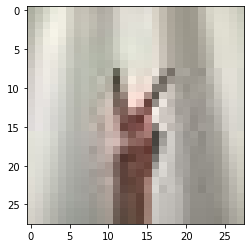

In [33]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네트워크 설계하기

In [34]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers)) 

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_5 (Dense)              (

### 딥러닝 네트워크 학습시키기

In [36]:
print("Before Reshape - x_train_norm shape: {}".format(x_train_norm.shape))
print("Before Reshape - x_test_norm shape: {}".format(x_test_norm.shape))

# 데이터갯수에 -1을 쓰면 reshape시 자동계산
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 1)

print("After Reshape - x_train_reshaped shape: {}".format(x_train_reshaped.shape))
print("After Reshape - x_test_reshaped shape: {}".format(x_test_reshaped.shape))

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_reshaped, y_train, epochs=10)

Before Reshape - x_train_norm shape: (300, 28, 28, 3)
Before Reshape - x_test_norm shape: (12, 28, 28, 3)
After Reshape - x_train_reshaped shape: (300, 28, 28, 3)
After Reshape - x_test_reshaped shape: (36, 28, 28, 1)
Epoch 1/10
10/10 [==============================] - 0s 3ms/step - loss: 1.1169 - accuracy: 0.2766
Epoch 2/10
10/10 [==============================] - 0s 3ms/step - loss: 1.0582 - accuracy: 0.3980
Epoch 3/10
10/10 [==============================] - 0s 3ms/step - loss: 0.9882 - accuracy: 0.7774
Epoch 4/10
10/10 [==============================] - 0s 3ms/step - loss: 0.8775 - accuracy: 0.7525
Epoch 5/10
10/10 [==============================] - 0s 3ms/step - loss: 0.7246 - accuracy: 0.8261
Epoch 6/10
10/10 [==============================] - 0s 3ms/step - loss: 0.5793 - accuracy: 0.9138
Epoch 7/10
10/10 [==============================] - 0s 3ms/step - loss: 0.4264 - accuracy: 0.9590
Epoch 8/10
10/10 [==============================] - 0s 3ms/step - loss: 0.3021 - accuracy: 0.969

### 테스트 데이터 만들기

In [35]:
import os

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")
    
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path = os.getenv("HOME") + "/aiffel/workplace/Exp1/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path = os.getenv("HOME") + "/aiffel/workplace/Exp1/rock_scissor_paper/test/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽음
image_dir_path = os.getenv("HOME") + "/aiffel/workplace/Exp1/rock_scissor_paper/test/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

# x_test, y_test 만들기
import numpy as np

# 가위바위보 이미지 개수 총합
def load_data(img_path, number_of_data=12):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/workplace/Exp1/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

4  images to be resized.
4  images resized.
가위 이미지 resize 완료!
4  images to be resized.
4  images resized.
바위 이미지 resize 완료!
4  images to be resized.
4  images resized.
보 이미지 resize 완료!
학습데이터(x_test)의 이미지 개수는 12 입니다.
x_test shape: (12, 28, 28, 3)
y_test shape: (12,)


### model을 사용하여 accuracy 측정하기

In [37]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)

print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

1/1 - 0s - loss: 152.8927 - accuracy: 0.5000
test_loss: 152.89271545410156 
test_accuracy: 0.5
